# HW3: Hamiltonian Monte Carlo


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Jake Taylor

**Names of any collaborators:** _Names here_

*Due: 11:59pm Friday, April 23, 2021 via GradeScope*

---

In this homework assignment you'll perform MCMC with both Metropolis-Hastings Hamiltonian Monte Carlo. We will investigate the Federalist papers---specifically, modeling the rate at which Hamilton (we're using HMC after all!) uses the word _can_ in his papers. 

We will fit this model using a negative binomial distribution. That is, for each document $n$ that Hamilton wrote, we have the number of times the word 'can' appears $y_n$ as 
\begin{align}
y_n \sim \text{NB}(\mu_n, r)
\end{align}
where 
\begin{align}
\text{NB}(y_n \mid \mu_n, r) = \frac{\Gamma(y_n+r)}{\Gamma(r) \Gamma(y_n+1)} \left(\frac{r}{\mu_n + r}\right)^r \left(1 - \frac{r}{\mu_n + r}\right)^{y_n}
\end{align}
The mean is given by $\mathbb{E}[y_n] = \mu_n$, and $r$ controls the dispersion. Here, we model the mean for document $n$ as
\begin{align}
\mu_n = \frac{T_n}{1000} \mu
\end{align}
where $\mu$ is the rate of usage of 'can' per 1000 words and $T_n$ is the number of words in document $n$ (i.e. the document length).

For our model, we will use the following prior for the non-negative parameters,
\begin{align}
\log \mu &\sim \mathcal{N}(0, 9) \\
\log r &\sim \mathcal{N}(0, 9)
\end{align}

In a classic paper, Mosteller and Wallace (JASA, 1963) used likelihood ratios under negative binomial models with different mean rates for Alexander Hamilton and James Madison to infer the more likely author of disputed Federalist papers. Spoiler alert: while Hamilton wrote the majority of the papers, the 12 disputed papers appear to be Madison's! A key step in their analysis was estimating the NB parameters. While Mosteller and Wallace used a point estimate for each word and author, you'll do full posterior inference, focusing on Hamilton's use of the word _can_.


In [1]:
!wget -nc https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw3/federalist_can_hamilton.csv

File ‘federalist_can_hamilton.csv’ already there; not retrieving.



In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load the data
df = pd.read_csv('federalist_can_hamilton.csv')
Ts = np.array(df['Total'])
ys = np.array(df['N'])
# preview data
list(zip(ys, Ts))[:5]

[(3, 1622), (5, 2511), (2, 2171), (4, 970), (14, 3095)]

## Problem 1  [math]: Show that the negative binomial can be expressed as the marginal distribution of a Poisson with gamma prior

Similar to how the Student's t distribution is a marginal of an inverse chi-squared and a Gaussian, show that

\begin{align}
\text{NB}(y \mid \mu, r) = \int \text{Po}(y \mid \lambda) \, \text{Ga}(\lambda \mid \alpha,\beta) \, \mathrm{d}\lambda
\end{align}

Express the parameters of the negative binomial distribution as a function of the parameters of the gamma distribution. (Assume $\beta$ is the rate parameter.)  
\begin{gather*}
\int Po(y | \lambda) Ga(\lambda | \alpha, \beta) d\lambda = \int \frac{\lambda^y e^{-y}}{y!}\frac{\lambda^{\alpha-1}e^{\beta\lambda}}{\beta^{-\alpha}\Gamma(\alpha)}d\lambda \\
=\frac{\beta^\alpha}{\Gamma(y+1)\Gamma(a)}\int \lambda^{\alpha + y - 1}e^{-\lambda(1 + \beta)} d\lambda\\
x = \lambda(1 + \beta),\frac{dx}{d\lambda} = (1+\beta),  z = \alpha + y\\
= \frac{\beta^\alpha}{\Gamma(y+1)\Gamma(a)}\int (\frac{x}{1 + \beta})^{\alpha + y - 1}e^{-x}d\lambda \frac{dx}{d\lambda} (1+\beta)^{-1}\\
=\frac{\beta^\alpha}{\Gamma(y+1)\Gamma(a)} (1 + \beta)^{-z + 1}(1 + \beta)^{-1}\int x^{z-1}e^{-x}dx\\
= \frac{\Gamma(\alpha + y)}{\Gamma(y+1)\Gamma(a)} \beta^\alpha (1 + \beta)^{-(\alpha + y)}\\
= \frac{\Gamma(\alpha + y)}{\Gamma(y+1)\Gamma(a)} \beta^\alpha (\frac{1}{1+\beta})^\alpha(\frac{1}{1+\beta})^y\\
\fbox{$\alpha = r$}, \frac{1}{1+\beta} = 1 - \frac{r}{\mu+ r} = \frac{\mu}{\mu + r} \implies \fbox{$\beta = \frac{r}{\mu}$}\\
= \frac{\Gamma(r + y)}{\Gamma(y+1)\Gamma(r)} (\frac{r}{\mu})^r (\frac{\mu}{\mu + r})^r(1 - \frac{r}{\mu+ r})^y \\
= \frac{\Gamma(r + y)}{\Gamma(y+1)\Gamma(r)} (\frac{r}{\mu + r})^r (1 - \frac{r}{\mu+ r})^y \\
= NB(y | \mu, r)\\
\implies r = \alpha, \mu = \frac{\alpha}{\beta}
\end{gather*}

## Problem 2: Implement the log joint probability of the model

In [94]:
import autograd.scipy.stats as ss
import autograd.scipy.special as sp

def log_joint(log_mu, log_r, ys=ys, Ts=Ts):
    N = len(ys)
    mu = np.exp(log_mu)
    r = np.exp(log_r)
    mus = (Ts / 1000.0) * mu
    p = r / (mus + r)
    likelihood = (np.sum(np.log(sp.gamma(ys + r)))
                  - np.sum(np.log(sp.gamma(ys + 1)))
                  - N * np.log(sp.gamma(r))
                  + np.sum(ys * np.log(1 - p))
                  + np.sum(r * np.log(p)))
    #likelihood = np.sum(ss.nbinom.logpmf(ys, n=r, p=p))
    r_prior = ss.norm.logpdf(log_r, 0.0, 3.0)
    mu_prior = ss.norm.logpdf(log_mu, 0.0, 3.0) 
    return  likelihood + r_prior + mu_prior

In [95]:
log_joint(ys=ys, Ts=Ts, log_mu=0, log_r=0)

-169.40747146591295

For the following MC implementation problems, sample in $\log(\mu), \log(r)$ space. Initialize with $\log(\mu) = 0, \log(r) = 0$.

## Problem 3: Implement Metropolis-Hastings

Implement and run Metropolis-Hastings with a spherical Gaussian proposal. Try various proposal variances.

In [82]:
def metropolis(log_mu=0,
               log_r=0,
               q_sigma = 1,
               iterations=100,
               lik=log_joint
              ):
    """ MCMC approximate inference """
    from scipy.stats import (multivariate_normal,
                             bernoulli)
    from numpy.random import rand
    theta = [log_mu, log_r]
    cache = [theta]
    for i in range(iterations):
        # proposal step
        theta_prime = multivariate_normal.rvs(mean=theta,
                               cov=np.diag([q_sigma] * 2),
                               size=1)
        
        # accept/ reject step
        A = np.exp(lik(theta_prime[0], theta_prime[1])
             - lik(theta[0], theta[1]))
        a = np.min([1.0, A])
        if bernoulli.rvs(p=a) == 1:
            theta = theta_prime
        cache.append(theta)
    return np.array(cache)

In [83]:
mcmc = metropolis(ys, Ts, q_sigma=0.1, iterations=10000)


## Problem 4: Implement Hamiltonian Monte Carlo

Implement the leapfrog step as a function, and run HMC. Try various step sizes and number of leapfrog steps.

In [178]:
def hamiltonian(log_mu=0.0,
                log_r=0.0,
                epsilon = 0.01,
                iterations=10000,
                leapfrog_steps=40,
                func=log_joint
              ):
    """ HMC approximate inference """
    from scipy.stats import (multivariate_normal,
                             bernoulli)
    from numpy.random import rand
    import autograd.numpy as np 
    import autograd.scipy.stats as ss
    import autograd.scipy.special as sp
    from autograd import grad
    from autograd.misc import flatten
    
    # Setup gradient function
    q, unflatten = flatten([log_mu, log_r])
    
    def U(params):
        log_mu, log_r = unflatten(params)
        return -log_joint(log_mu, log_r)

    grad_U = grad(U)
    current_q = q
    cache = [q]
    for i in range(iterations):
        # proposal step
        p = multivariate_normal.rvs(mean=[0, 0],
                               cov=np.diag([1, 1]),
                               size=1)
        current_p = p
        
        # First half step
        p = p - epsilon * grad_U(q) / 2
        
        # Alternate full steps for position and momentum
        for j in range(leapfrog_steps):
            q = q + epsilon * p
            if j != leapfrog_steps-1:
                # Full step when not at end of trajectory
                p = p - epsilon * grad_U(q)
        
        # half step for momentum at end
        p = p - epsilon * grad_U(q) / 2
        
        # negate p to make proposal symmetric
        p = -p
        
        current_U = U(current_q)
        current_K = np.sum(np.power(current_p, 2)) / 2
        proposed_U = U(q)
        proposed_K = np.sum(np.power(p, 2)) / 2
        
        # accept/ reject step
        A = np.exp(current_U - proposed_U + current_K - proposed_K)
        a = np.min([1.0, A])
        if bernoulli.rvs(p=a) == 1:
            current_q = q
        cache.append(current_q)
    return np.array(cache)

In [179]:
hmc = hamiltonian()

## Problem 5: Diagnostics

For both algorithms, make trace plots of the parameters and plot histograms of posterior marginals.

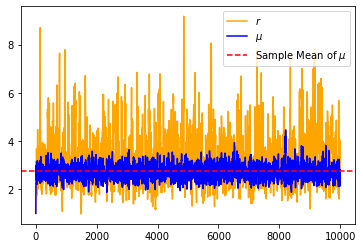

In [171]:
plt.plot(np.exp(mcmc[:,1]), color = 'orange',  label = r'$r$')
plt.plot(np.exp(mcmc[:,0]), color = 'blue', label = r'$\mu$')
plt.axhline((df.N * 1000 / df.Total).mean(),
            color='red', 
            ls='--',
            label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

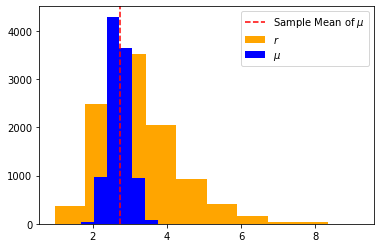

In [172]:
plt.hist(np.exp(mcmc[:,1]), color='orange', label = r'$r$')
plt.hist(np.exp(mcmc[:,0]), color='blue', label = r'$\mu$')
plt.axvline((df.N * 1000 / df.Total).mean(), color='red', ls='--', label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

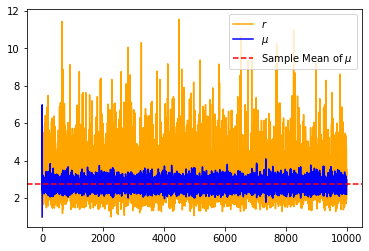

In [180]:
plt.plot(np.exp(hmc[:,1]), color = 'orange',  label = r'$r$')
plt.plot(np.exp(hmc[:,0]), color = 'blue', label = r'$\mu$')
plt.axhline((df.N * 1000 / df.Total).mean(),
            color='red', 
            ls='--',
            label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

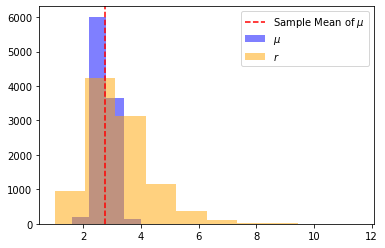

In [181]:
plt.hist(np.exp(hmc[:,0]), color='blue', alpha = 0.5, label = r'$\mu$')
plt.hist(np.exp(hmc[:,1]), color='orange', alpha = 0.5, label = r'$r$')
plt.axvline((df.N * 1000 / df.Total).mean(), color='red', ls='--', label=r'Sample Mean of $\mu$')
plt.legend()
plt.show()

## Problem 6: Effective Sample Size

Calculate effective sample size for both chains.

In [162]:
import tensorflow_probability as tfp

In [165]:
ess = tfp.mcmc.effective_sample_size(mcmc, filter_beyond_positive_pairs=True)
print(ess)

tf.Tensor([1695.60398171  588.14185735], shape=(2,), dtype=float64)


In [182]:
ess = tfp.mcmc.effective_sample_size(hmc, filter_beyond_positive_pairs=True)
print(ess)

tf.Tensor([42821.14201287  4194.85155251], shape=(2,), dtype=float64)


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw3_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
